# Import necessary libraries

In [3]:
%pip install tensorflow scikit-image

     --------------------------------------- 12.2/12.2 MB 10.9 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 10.8 MB/s eta 0:00:00
     -------------------------------------- 208.5/208.5 kB 6.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform, exposure, io
import random
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Exploratory Data Analysis

The dataset has already been split into training and testing subsets with a ratio of approximately 12000:39000, which corresponds roughly to a 20:80 test-train split.

In [6]:
data = pd.read_csv("./gtsrb/Train.csv")
data.shape

(39209, 8)

In [7]:
data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:
data.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


Notice that the standard deviation for the "ClassId" field is rather high for a field that contains only 43 unique values. This indicates that there is an inequal distribution among the different categories of pictures. We can verify this by looking at a bar chart of the categories. For ease of visualization, the bars have been sorted in ascending order.

<AxesSubplot:xlabel='ClassId'>

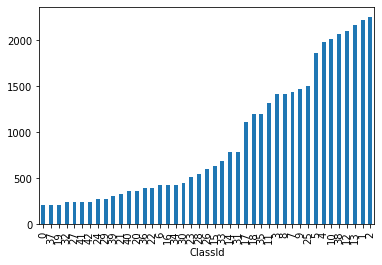

In [9]:
data.groupby("ClassId")["ClassId"].count().sort_values().plot.bar()

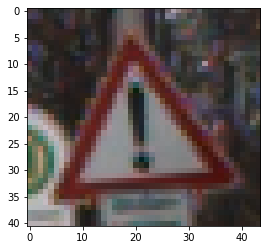

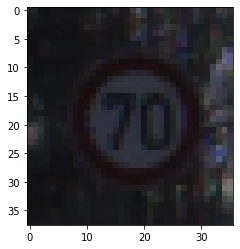

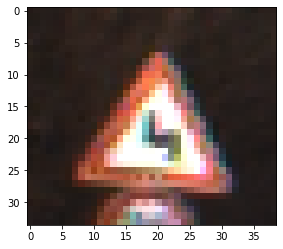

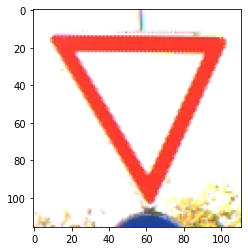

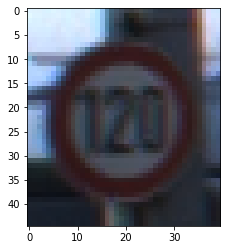

In [15]:
random.seed(1102022)
randIdx = list(random.sample(range(0, data.shape[0]), 5))
for i in randIdx:
    img = mpimg.imread(os.path.join("./gtsrb", data.loc[i]["Path"]))
    plt.figure()
    plt.imshow(img)

Examining some of the above images, we see that they are quite pixelated and have poor contrast. We address this issue during the preprocessing step when we apply a contrast enhancing algorithm to improve training. In this notebook, we will see the performance of models trained both with and without this preprocessing step and compare the two.

In [2]:
NUM_EPOCHS = 30
LEARNING_RATE = 1e-2
BATCH_SIZE = 64

In [3]:
class TrafficSignDetector:
    def build(imageWidth, imageHeight, imageDepth, numClasses):
        inputShape = (imageHeight, imageWidth, imageDepth)
        channelDimension = -1
        
        # Initialize model
        model = Sequential()
        
        # Three sets of (Conv2D, RelU, BatchNormalization, MaxPooling2D) layers with increasing filter size
        model.add(Conv2D(8, (5,5), input_shape=inputShape, padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        # Set 2
        model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # Set 3
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # First fully-connected -> RelU layer
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5)) # Regularization
        
        # Second fully-connected -> RelU layer
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.2)) # Regularization
        
        # Final classification layer with softmax activation function
        model.add(Dense(numClasses, activation="softmax"))

        return model
    
    def build2(imageWidth, imageHeight, imageDepth, numClasses):
        inputShape = (imageHeight, imageWidth, imageDepth)
        channelDimension = -1
        
        # Initialize model
        model = Sequential()
        
        # 4 sets of convolution
        model.add(Conv2D(16, kernel_size=(3,3), padding="same", input_shape=inputShape, activation="relu"))
#         model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu"))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(numClasses, activation="softmax"))

        return model
    
    def build3(imageWidth, imageHeight, imageDepth, numClasses):
        inputShape = (imageHeight, imageWidth, imageDepth)
        channelDimension = -1
        
        # Initialize model
        model = Sequential()
        
        # Three sets of (Conv2D, RelU, BatchNormalization, MaxPooling2D) layers with increasing filter size
        model.add(Conv2D(8, (5,5), input_shape=inputShape, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        # Set 2
        model.add(Conv2D(16, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # Set 3
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # Classification part
        
        # First fully-connected -> RelU layer
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5)) # Regularization
        
        # Softmax classifier
        model.add(Dense(numClasses))
        model.add(Activation("softmax"))

        return model
    
    def build4(imageWidth, imageHeight, imageDepth, numClasses):
        inputShape = (imageHeight, imageWidth, imageDepth)
        channelDimension = -1
        
        # Initialize model
        model = Sequential()
        
        # Three sets of (Conv2D, RelU, BatchNormalization, MaxPooling2D) layers with increasing filter size
        model.add(Conv2D(16, (5,5), input_shape=inputShape, padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        # Set 2
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # Set 3
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization(axis=channelDimension))
        model.add(MaxPooling2D(pool_size=(2, 2))) # To reduce dimensionality
        
        # First fully-connected -> RelU layer
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5)) # Regularization
        
        # Second fully-connected -> RelU layer
        model.add(Flatten())
        model.add(Dense(units=128, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.2)) # Regularization
        
        # Final classification layer with softmax activation function
        model.add(Dense(numClasses, activation="softmax"))

        return model

In [ ]:
def process_image(imagePath: str, preprocessing:bool =True, clahe: bool=True):
    image = io.imread(imagePath)

    # Resize image to 32 pixels x 32 pixels
    image = transform.resize(image=image, output_shape=(32,32))

    # Apply preprocessing algorithm, if enabled
    if (preprocessing):
            if (clahe):
                # Improve contrast of images using CLAHE algorithm
                image = exposure.equalize_adapthist(image=image, clip_limit=0.1)
            else:
                # Improve contrast of images
                image = exposure.equalize_hist(image=image)

    return image

: 

In [5]:
def load_and_split_data(basePath:str, csvPath:str, preprocessing: bool=True, clahe: bool=True):
    data = []
    labels = []
    
    rows = open(csvPath).read().strip().split("\n")[1:] # Ignore the first row since it's the header
    random.shuffle(rows)
    
    # Loop over rows and preprocess the data
    for (i, row) in enumerate(rows):
        if (i > 0) and (i % 1000 == 0):
            print(f"[INFO] processed {i} total images")
            
        (label, imagePath) = row.strip().split(",")[-2:] # Last two entries
        
         # Load image for preprocessing
        imagePath = os.path.sep.join([basePath, imagePath])
        image = process_image(imagePath, preprocessing, clahe)        
        data.append(image)
        labels.append(int(label))
        
    data = np.array(data)
    labels = np.array(labels)
    
    return (data, labels)

In [14]:
def plot_history(history, numEpochs):
    N = np.arange(0, numEpochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, history.history["loss"], label="train_loss")
    plt.plot(N, history.history["val_loss"], label="val_loss")
    plt.plot(N, history.history["accuracy"], label="train_acc")
    plt.plot(N, history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")
    # plt.savefig("plot.png")
    plt.show()

In [7]:
labelNames = open("./gtsrb/signnames.csv").read().strip().split("\n")[1:] # Get rid of header
labelNames = [line.split(",")[1] for line in labelNames]
# labelNames = pd.read_csv("./gtsrb/Train.csv")
basePath = "./gtsrb"
trainPath = os.path.join(basePath, "Train.csv")
testPath = os.path.join(basePath, "Test.csv")

print(len(labelNames))

43


In [ ]:
def show_predictions(model, labels, basePath: str, csvPath: str, preprocessing: bool=True, clahe:bool=True):
    plt.figure(figsize = (12,12))
    rows = open(csvPath).read().strip().split("\n")[1:]
    numLabels = len(labels)

    for i in range(6):
        data = []
        x = np.random.randint(0, 500)
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])

        # Preprocess image
        (label, imagePath) = rows[x].strip().split(",")[-2:] # Get ClassId and Path
        label = int(label)

        imagePath = os.path.sep.join([basePath, imagePath])
        image = process_image(imagePath, preprocessing, clahe)
        data.append(image)
        data = np.array(data)

        img = mpimg.imread(imagePath)
        
        # Plot the figure
        plt.title(labels[label], fontsize = 12)
        plt.imshow(img)

        data = data.astype(float) / 255.0

        pred = model.predict(data)

        color = 'green' if (np.argmax(pred) == label) else 'red'

        # Put appropriate text and color
        plt.xlabel("Prediction: \n" + labels[np.argmax(pred)], color=color)
        plt.grid()
    plt.tight_layout()
    plt.show()

# Without image preprocessing

In [20]:
print("[INFO] Loading traning and testing data")
(trainX_without_preproc, trainY_without_preproc) = load_and_split_data(basePath, trainPath, False)
(testX_without_preproc, testY_without_preproc) = load_and_split_data(basePath, testPath, False)

# Scale data to [0, 1]
trainX_without_preproc = trainX_without_preproc.astype(float) / 255.0
testX_without_preproc = testX_without_preproc.astype(float) / 255.0

# One-hot encoding of labels
numLabels = len(np.unique(trainY_without_preproc))
trainY_without_preproc = to_categorical(trainY_without_preproc, num_classes=numLabels)
testY_without_preproc = to_categorical(testY_without_preproc, num_classes=numLabels)

[INFO] Loading traning and testing data
[INFO] processed 1000 total images


KeyboardInterrupt: 

The following part stays constant.

In [33]:
# Calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY_without_preproc.sum(axis=0)
classWeight = dict()

# Loop over all classes and calculate the class weight
# This is done because the data is skewed, i.e. there
# sizes of all classes are not the same, so we must
# account for that by assigning weights to each class
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
    
# Image augmentation for model robustness
augmenter = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.15,
                               horizontal_flip=False,
                               vertical_flip=False,
                               fill_mode="nearest")

optimizer = Adam(learning_rate=LEARNING_RATE) #, decay= (LEARNING_RATE / (NUM_EPOCHS * 0.5)))

In [34]:
# Initialize optimizer and compile the model
print("[INFO] Compiling model...")

clear_session()

model_without_preproc = TrafficSignDetector.build(imageWidth=32, imageHeight=32, imageDepth=3, numClasses=numLabels)
model_without_preproc.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print("[INFO] Compiled model")
model_without_preproc.summary()

[INFO] Compiling model...
[INFO] Compiled model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_no

In [35]:
print("[INFO] Training network...")
history = model_without_preproc.fit(augmenter.flow(trainX_without_preproc, trainY_without_preproc, batch_size=BATCH_SIZE),
                   validation_data=(testX_without_preproc, testY_without_preproc),
                   epochs=NUM_EPOCHS,
                   class_weight=classWeight,
                   verbose=1)

[INFO] Training network...
Epoch 1/30
613/613 [==============================] - 28s 43ms/step - loss: 7.2348 - accuracy: 0.1540 - val_loss: 3.1841 - val_accuracy: 0.1978
Epoch 2/30
613/613 [==============================] - 26s 42ms/step - loss: 3.4475 - accuracy: 0.5110 - val_loss: 1.2025 - val_accuracy: 0.6168
Epoch 3/30
613/613 [==============================] - 26s 42ms/step - loss: 2.0068 - accuracy: 0.6949 - val_loss: 0.6925 - val_accuracy: 0.7831
Epoch 4/30
613/613 [==============================] - 25s 41ms/step - loss: 1.3660 - accuracy: 0.7883 - val_loss: 0.4853 - val_accuracy: 0.8546
Epoch 5/30
613/613 [==============================] - 26s 43ms/step - loss: 0.9797 - accuracy: 0.8417 - val_loss: 0.4314 - val_accuracy: 0.8721
Epoch 6/30
613/613 [==============================] - 26s 43ms/step - loss: 0.8811 - accuracy: 0.8613 - val_loss: 0.4738 - val_accuracy: 0.8706
Epoch 7/30
613/613 [==============================] - 26s 43ms/step - loss: 0.7348 - accuracy: 0.8869 - val_l

[INFO] Evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.16      0.22      0.18        60
                              Speed limit (30km/h)       0.46      0.03      0.06       720
                              Speed limit (50km/h)       0.73      0.05      0.09       750
                              Speed limit (60km/h)       0.07      0.03      0.04       450
                              Speed limit (70km/h)       1.00      0.00      0.01       660
                              Speed limit (80km/h)       0.41      0.12      0.18       630
                       End of speed limit (80km/h)       0.00      0.00      0.00       150
                             Speed limit (100km/h)       0.00      0.00      0.00       450
                             Speed limit (120km/h)       0.00      0.00      0.00       450
                                        No passing

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


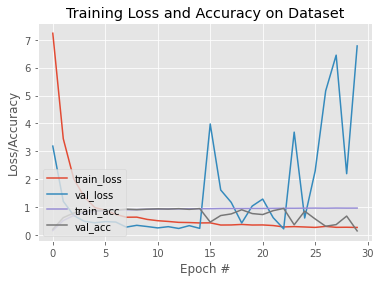

[INFO] Serializing network to 'model_without_preproc.h5'...


In [38]:
# Evaluate the network
print("[INFO] Evaluating network...")
predictions = model_without_preproc.predict(testX_without_preproc, batch_size=BATCH_SIZE)
print(classification_report(testY_without_preproc.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

modelName = "model_without_preproc.h5"
plot_history(history, NUM_EPOCHS)

# Save the network to disk
print(f"[INFO] Serializing network to '{modelName}'...")
model_without_preproc.save(modelName)

In [ ]:
# Visualize predictions
show_predictions(model_without_preproc, labelNames, basePath, testPath, True, True)

As expected, the performance of the model on the raw images is abysmal.

# With image preprocessing (1)

In [16]:
print("[INFO] Loading traning and testing data")
(trainX_with_preproc1, trainY_with_preproc1) = load_and_split_data(basePath, trainPath, True, False)
(testX_with_preproc1, testY_with_preproc1) = load_and_split_data(basePath, testPath, True, False)

# Scale data to [0, 1]
trainX_with_preproc1 = trainX_with_preproc1.astype(float) / 255.0
testX_with_preproc1 = testX_with_preproc1.astype(float) / 255.0

# One-hot encoding of labels
trainY_with_preproc1 = to_categorical(trainY_with_preproc1, num_classes=numLabels)
testY_with_preproc1 = to_categorical(testY_with_preproc1, num_classes=numLabels)

[INFO] Loading traning and testing data


c:\Python38\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total images
[INFO] processed 28000 total images
[

In [17]:
# Compile the model
print("[INFO] Compiling model...")
clear_session()

model_with_preproc1 = TrafficSignDetector.build(imageWidth=32, imageHeight=32, imageDepth=3, numClasses=numLabels)
model_with_preproc1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print("[INFO] Compiled model")
model_with_preproc1.summary()

[INFO] Compiling model...
[INFO] Compiled model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
        

In [18]:
# Train the network
print("[INFO] Training network...")
history = model_with_preproc1.fit(augmenter.flow(trainX_with_preproc1, trainY_with_preproc1, batch_size=BATCH_SIZE),
                   validation_data=(testX_with_preproc1, testY_with_preproc1),
                   epochs=NUM_EPOCHS,
                   class_weight=classWeight,
                   verbose=1)

[INFO] Training network...
Epoch 1/30
613/613 [==============================] - 60s 95ms/step - loss: 7.3536 - accuracy: 0.1484 - val_loss: 2.8359 - val_accuracy: 0.1319
Epoch 2/30
613/613 [==============================] - 64s 104ms/step - loss: 4.1681 - accuracy: 0.4366 - val_loss: 1.3489 - val_accuracy: 0.5264
Epoch 3/30
613/613 [==============================] - 60s 98ms/step - loss: 2.8897 - accuracy: 0.5816 - val_loss: 1.0426 - val_accuracy: 0.6438
Epoch 4/30
613/613 [==============================] - 45s 73ms/step - loss: 2.0863 - accuracy: 0.6798 - val_loss: 0.7839 - val_accuracy: 0.7278
Epoch 5/30
613/613 [==============================] - 44s 72ms/step - loss: 1.6251 - accuracy: 0.7470 - val_loss: 0.7414 - val_accuracy: 0.7488
Epoch 6/30
613/613 [==============================] - 44s 72ms/step - loss: 1.3024 - accuracy: 0.7891 - val_loss: 0.4706 - val_accuracy: 0.8463
Epoch 7/30
613/613 [==============================] - 44s 71ms/step - loss: 1.1191 - accuracy: 0.8258 - val_

[INFO] Evaluating network...
198/198 [==============================] - 3s 12ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.88      0.97      0.92        60
                              Speed limit (30km/h)       0.93      0.92      0.92       720
                              Speed limit (50km/h)       0.92      0.93      0.92       750
                              Speed limit (60km/h)       0.99      0.94      0.96       450
                              Speed limit (70km/h)       0.90      0.95      0.92       660
                              Speed limit (80km/h)       0.94      0.73      0.82       630
                       End of speed limit (80km/h)       0.94      0.83      0.88       150
                             Speed limit (100km/h)       0.83      0.93      0.88       450
                             Speed limit (120km/h)       0.90      0.98      0.94     

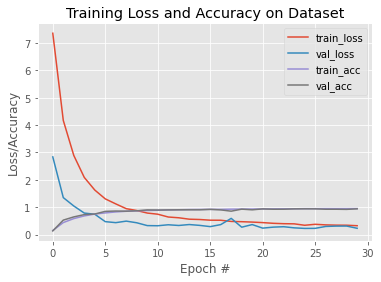

[INFO] Serializing network to 'model_with_preproc1.h5'...


ValueError: Unable to create dataset (name already exists)

In [19]:
# Evaluate the network
print("[INFO] Evaluating network...")
predictions = model_with_preproc1.predict(testX_with_preproc1, batch_size=BATCH_SIZE)
print(classification_report(testY_with_preproc1.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

modelName = "model_with_preproc1.h5"
plot_history(history, NUM_EPOCHS)

# Save the network to disk
print(f"[INFO] Serializing network to '{modelName}'...")
model_with_preproc1.save(modelName)

In [ ]:
# Visualize predictions
show_predictions(model_with_preproc1, labelNames, basePath, testPath, True, True)

The performance is much better in comparison to the case without image preprocessing, but it is still not very good. Lastly, we will try another method for image preprocessing and compare the results. 

# With image preprocessing (2)

In [9]:
print("[INFO] Loading traning and testing data")
(trainX_with_preproc2, trainY_with_preproc2) = load_and_split_data(basePath, trainPath, True, True)
(testX_with_preproc2, testY_with_preproc2) = load_and_split_data(basePath, testPath, True, True)

# Scale data to [0, 1]
trainX_with_preproc2 = trainX_with_preproc2.astype(float) / 255.0
testX_with_preproc2 = testX_with_preproc2.astype(float) / 255.0

# One-hot encoding of labels
numLabels = len(np.unique(trainY_with_preproc2))
trainY_with_preproc2 = to_categorical(trainY_with_preproc2, num_classes=numLabels)
testY_with_preproc2 = to_categorical(testY_with_preproc2, num_classes=numLabels)

[INFO] Loading traning and testing data
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total imag

In [10]:
# Calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY_with_preproc2.sum(axis=0)
classWeight = dict()

# Loop over all classes and calculate the class weight
# This is done because the data is skewed, i.e. there
# sizes of all classes are not the same, so we must
# account for that by assigning weights to each class
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
    
# Image augmentation for model robustness
augmenter = ImageDataGenerator(rotation_range=10,
                               zoom_range=0.15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.15,
                               horizontal_flip=False,
                               vertical_flip=False,
                               fill_mode="nearest")

optimizer = Adam(learning_rate=LEARNING_RATE) #, decay= (LEARNING_RATE / (NUM_EPOCHS * 0.5)))

In [11]:
# Compile the model
print("[INFO] Compiling model...")
clear_session()

model_with_preproc2 = TrafficSignDetector.build(imageWidth=32, imageHeight=32, imageDepth=3, numClasses=numLabels)
model_with_preproc2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print("[INFO] Compiled model")
model_with_preproc2.summary()

[INFO] Compiling model...
[INFO] Compiled model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         608       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
        

In [12]:
# Train the network
print("[INFO] Training network...")
history = model_with_preproc2.fit(augmenter.flow(trainX_with_preproc2, trainY_with_preproc2, batch_size=BATCH_SIZE),
                   validation_data=(testX_with_preproc2, testY_with_preproc2),
                   epochs=NUM_EPOCHS,
                   class_weight=classWeight,
                   verbose=1)

[INFO] Training network...
Epoch 1/30
613/613 [==============================] - 48s 76ms/step - loss: 4.6890 - accuracy: 0.4133 - val_loss: 2.1417 - val_accuracy: 0.4633
Epoch 2/30
613/613 [==============================] - 48s 79ms/step - loss: 2.1274 - accuracy: 0.6931 - val_loss: 0.8136 - val_accuracy: 0.7457
Epoch 3/30
613/613 [==============================] - 46s 75ms/step - loss: 1.4829 - accuracy: 0.7746 - val_loss: 0.4195 - val_accuracy: 0.8600
Epoch 4/30
613/613 [==============================] - 46s 74ms/step - loss: 1.1708 - accuracy: 0.8216 - val_loss: 0.3341 - val_accuracy: 0.8953
Epoch 5/30
613/613 [==============================] - 51s 83ms/step - loss: 0.9997 - accuracy: 0.8489 - val_loss: 0.2870 - val_accuracy: 0.9088
Epoch 6/30
613/613 [==============================] - 52s 84ms/step - loss: 0.8798 - accuracy: 0.8680 - val_loss: 0.3863 - val_accuracy: 0.8900
Epoch 7/30
613/613 [==============================] - 52s 85ms/step - loss: 0.8015 - accuracy: 0.8828 - val_l

[INFO] Evaluating network...
198/198 [==============================] - 3s 14ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.66      1.00      0.79        60
                              Speed limit (30km/h)       0.98      0.94      0.96       720
                              Speed limit (50km/h)       0.97      0.93      0.95       750
                              Speed limit (60km/h)       0.88      0.97      0.92       450
                              Speed limit (70km/h)       0.98      0.91      0.94       660
                              Speed limit (80km/h)       0.92      0.90      0.91       630
                       End of speed limit (80km/h)       0.96      0.87      0.91       150
                             Speed limit (100km/h)       0.92      0.98      0.95       450
                             Speed limit (120km/h)       0.95      0.94      0.94     

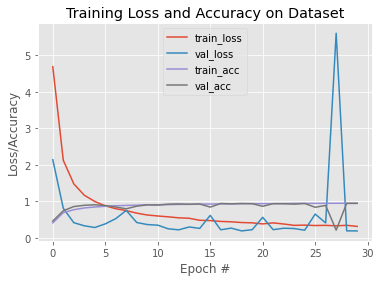

[INFO] Serializing network to 'model_with_preproc2.h5'...


In [15]:
# Evaluate the network
print("[INFO] Evaluating network...")
predictions = model_with_preproc2.predict(testX_with_preproc2, batch_size=BATCH_SIZE)
print(classification_report(testY_with_preproc2.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=labelNames))

modelName = "model_with_preproc2.h5"
plot_history(history, NUM_EPOCHS)

# Save the network to disk
print(f"[INFO] Serializing network to '{modelName}'...")
model_with_preproc2.save(modelName)

In [ ]:
# Visualize predictions
show_predictions(model_with_preproc2, labelNames, basePath, testPath, True, True)